This notebook showcases the downsampling scheme I developed in Summer 2017, to make a DESI-like sample. This is done by first abundance matchhing to the GAMA Luminosity function from [Loveday 2015](https://arxiv.org/abs/1505.01003), then downsampling to match what we expect from DESI by matching a catalog made by Song. 

There are a few python packages I use in this notebook that will need to be installed before running. 
* [Yao's code](https://bitbucket.org/yymao/abundancematching) to do the abundance matching. 
* Loading particles from disk requires one of Yao's other packages, [helpers](https://bitbucket.org/yymao/helpers/src). 
* Also, I used [Halotools](https://halotools.readthedocs.io/en/latest/), specifically the halo catalog loading and caching functionalities. 

In [1]:
from glob import glob
from os import path
import numpy as np
from halotools.sim_manager import CachedHaloCatalog, RockstarHlistReader, UserSuppliedPtclCatalog
from helpers.readGadgetSnapshot import readGadgetSnapshot
from AbundanceMatching import *

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#details of the catalog we're going to load; insert your info here.
simname = 'chinchilla'
Lbox = 400
npart = 2048

z = 0.2
a = 1/(1+z)

In [4]:
# This dictionary is a required input for the halotools loader. It details what columns we want and where they're located
# in the table. Yours may differ, so check! 
HLIST_COLS = {'halo_id': (1, 'i8'), 'halo_upid': (6, 'i8'),
              'halo_x': (17, 'f4'), 'halo_y': (18, 'f4'), 'halo_z': (19, 'f4'),
              'halo_vx': (20, 'f4'), 'halo_vy': (21, 'f4'), 'halo_vz': (22, 'f4'),
              'halo_mvir': (10, 'f4'), 'halo_rvir': (11, 'f4'), 'halo_rs':(12, 'f4'),
              'halo_snapnum': (31, 'i8'),'halo_vpeak':(57, 'f8'), 'halo_halfmass_scale': (58, 'f4')}

In [5]:
#Where the halo catalog is located on disk
loc = '/nfs/slac/g/ki/ki21/cosmo/yymao/sham_test/resolution-test/'
columns_to_keep = HLIST_COLS
#convert halo radii from kpc to Mpc
columns_to_convert = list(set(["halo_rvir", "halo_rs"])& set( columns_to_keep.keys()) )

halo_finder = 'rockstar'

# This is particular to my chinchilla caching scheme, so you should ignore this. ##########################
pmass = 1.44390e+08*((Lbox / 125.0) ** 3) * ((1024.0/npart)** 3)
valid_version_names = {'Lb125-1024', 'Lb125-2048', 'Lb250-1024', 'Lb250-128',
                        'Lb250-196', 'Lb250-2048', 'Lb250-2560', 'Lb250-320',
                        'Lb250-512', 'Lb250-768', 'Lb250-85', 'Lb400-1024',
                        'Lb400-136', 'Lb400-2048', 'Lb400-210', 'Lb400-315',
                        'Lb400-512', 'Lb400-768'}
#check that this combination of lbox and npart exists
version_name = 'Lb%d-%d' % (int(Lbox), npart)
assert version_name in valid_version_names
#########################################################################################
loc += 'c%d-%d/' % (int(Lbox), int(npart)) #add the subdirectory, also only relevant for Chinchilla

#where are the particles located on disk? 
gadget_loc = loc
loc += '/rockstar/hlists/'
gadget_loc+='/output/'

#Specify where to cache the halo, and make it unique if we're caching multiple versions
cache_loc ='/u/ki/swmclau2/des/halocats/hlist_%.2f.list.%s_%s.hdf5'
cache_filename = cache_loc % (a, simname, version_name)  # make sure we don't have redunancies.

In [6]:
# This cell identifies from all available hlists in the directory, which corresponds to the scale factor we're interested in
# Your file formats may differ, so you may have to hardcode the fname you want, or tweak this automatic finding i've implemented
tmp_fnames = sorted(glob(loc + 'hlist_*.list'))  # snag all the hlists
available_fnames = [fname[len(loc):] for fname in tmp_fnames]  # just want the names in the dir
available_scale_factors = [float(fname[6:-5]) for fname in available_fnames]  # pull out scale factors
 
idx = np.argmin(np.abs(np.array(available_scale_factors) - a))

The cell immeadiately below, and the next few, are only necessary for the first run. They cahce the halo catalog to disk. It takes a little while, and is unecessary to run more than once. You should change the cell type to `Raw NBConvert` once they've been run once. 

In [ ]:
fname = path.join(loc, available_fnames[idx])
#Load the halocat, and cache it for easier reading later. 
reader = RockstarHlistReader(fname, columns_to_keep, cache_filename, simname,
                             halo_finder, z, version_name, Lbox, pmass,
                             overwrite=True)
reader.read_halocat(columns_to_convert, write_to_disk=True, update_cache_log=True)

Likewise, we have to select a particle catalog, too. 

In [ ]:
# select all particle snapshots in the gadget file location. once could also just specify the snapdir
all_snapdirs = glob(path.join(gadget_loc, 'snapdir*'))
snapdir = all_snapdirs[idx]#only the snapdir for the scale factor were interested in .

In [ ]:
# Downsample the particles
np.random.seed(56789)
p = 1e-3 #downsampling factor
all_particles = np.array([], dtype='float32')
# TODO should fail gracefully if memory is exceeded or if p is too small.
for file in glob(path.join(snapdir, 'snapshot*')):
    # TODO should find out which is "fast" axis and use that.
    # Numpy uses fortran ordering.
    particles = readGadgetSnapshot(file, read_pos=True)[1]  # Think this returns some type of tuple; should check
    downsample_idxs = np.random.choice(particles.shape[0], size =int( particles.shape[0]*p))
    particles = particles[downsample_idxs, :]
    #particles = particles[np.random.rand(particles.shape[0]) < p]  # downsample
    if particles.shape[0] == 0:
        continue

    all_particles = np.resize(all_particles, (all_particles.shape[0] + particles.shape[0], 3))
    all_particles[-particles.shape[0]:, :] = particles

In [ ]:
# save the particles to disk somewhere, just so we don't have to do the above again
np.savetxt('/u/ki/swmclau2/des/ptcl_catalog.npy', all_particles)

In [ ]:
# cache the particles, and pair it to the halos so halotools knows where it its when we load the sim. 
ptcl_catalog = UserSuppliedPtclCatalog(redshift=z, Lbox=Lbox, particle_mass=pmass,\
                                       x=all_particles[:,0], y=all_particles[:,1], z=all_particles[:,2])
ptcl_cache_loc ='/u/ki/swmclau2/des/halocats/ptcl_%.2f.list.%s_%s.hdf5'
ptcl_cache_filename = ptcl_cache_loc % (a, simname, version_name)  # make sure we don't have redunancies.
ptcl_catalog.add_ptclcat_to_cache(ptcl_cache_filename, simname, version_name, 'p=%f'%p)

We've finished with caching; you can deactivate the above cells after you've finished. 

In [7]:
#load our catalog from disk
halocat = CachedHaloCatalog(simname = simname,halo_finder= halo_finder, redshift = z, version_name=version_name,dz_tol = 0.01)

In [8]:
halocat.halo_table.colnames

['halo_upid',
 'halo_y',
 'halo_x',
 'halo_z',
 'halo_rvir',
 'halo_vpeak',
 'halo_snapnum',
 'halo_halfmass_scale',
 'halo_id',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_rs',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_hostid',
 'halo_mvir_host_halo']

Loading up a luminosity function. This one is from GAMA Survey, Loveday 2015. Note the selected redshift ranges. 

In [9]:
lf = np.genfromtxt('lf_r_sersic_z_0.2_0.3.dat', skip_header=True)[:,1:3]
#lf = np.genfromtxt('lf_r_sersic_z_0.1_0.2.dat', skip_header=True)[:,1:3]

In [10]:
lf

array([[ -2.38800000e+01,   3.93000000e-07],
       [ -2.33800000e+01,   1.87000000e-06],
       [ -2.31200000e+01,   7.22000000e-06],
       [ -2.28800000e+01,   1.87000000e-05],
       [ -2.26200000e+01,   4.10000000e-05],
       [ -2.23800000e+01,   1.09000000e-04],
       [ -2.21200000e+01,   2.16000000e-04],
       [ -2.18800000e+01,   3.88000000e-04],
       [ -2.16200000e+01,   7.28000000e-04],
       [ -2.13800000e+01,   1.17000000e-03],
       [ -2.11200000e+01,   1.80000000e-03],
       [ -2.08800000e+01,   2.52000000e-03],
       [ -2.06200000e+01,   3.33000000e-03],
       [ -2.03800000e+01,   4.20000000e-03],
       [ -2.01200000e+01,   4.87000000e-03],
       [ -1.98800000e+01,   6.02000000e-03],
       [ -1.96200000e+01,   6.58000000e-03],
       [ -1.93800000e+01,   5.65000000e-03],
       [ -1.91200000e+01,   1.03000000e-03],
       [ -1.88800000e+01,   7.84000000e-05],
       [ -1.86200000e+01,   4.93000000e-04],
       [ -1.83800000e+01,   2.24000000e-04],
       [ -

In [12]:
# apologies for the magic numbers. I tinkered with this particular LF for a while, since the edges get a little 
# noisy. This seemed to give the best extrapolation, but feel free to change. 
use_up_to = -6
af = AbundanceFunction(lf[:use_up_to,0], lf[:use_up_to,1], (-27, -18),faint_end_fit_points = 7 )

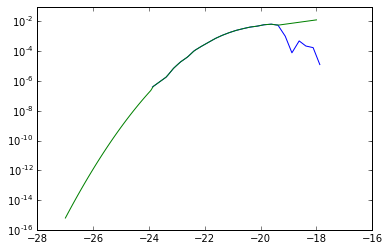

In [13]:
plt.semilogy(lf[:,0], lf[:,1])
x = np.linspace(-27, -18, 101)
plt.semilogy(x, af(x))

In [14]:
print max(af(x))

0.0128038958073


These checks are reccomended by Yao in his code, linked above.

In [15]:
scatter = 0.2
remainder = af.deconvolute(scatter*LF_SCATTER_MULT, 20)

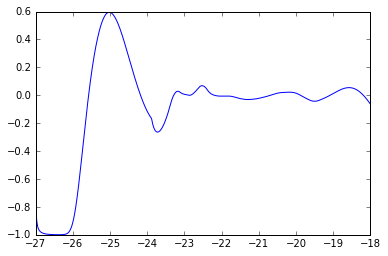

In [16]:
x, nd = af.get_number_density_table()
plt.plot(x, remainder/nd);

In [17]:
max(nd)

0.020700864149967049

In [18]:
# calculate the number density of our halo proxy
halos = np.array(halocat.halo_table)
    
nd_halos = calc_number_densities(halos['halo_vpeak'], halocat.Lbox[0])

In [19]:
# Do the AB match here. 
full_catalog = af.match(nd_halos, scatter*LF_SCATTER_MULT)

In [20]:
mag_cut = -18 # choose a magitude cut, and make this cut on our sample
valid_idxs = np.logical_and(~np.isnan(full_catalog), full_catalog <= mag_cut)
catalog = full_catalog[valid_idxs]

/afs/slac.stanford.edu/u/ki/swmclau2/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


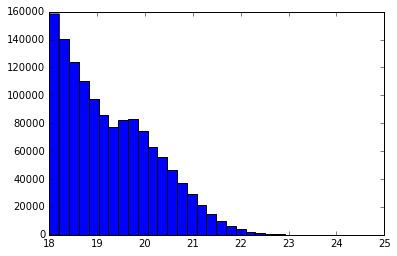

In [21]:
plt.hist(-1*catalog, bins = 30);

We want this plot to approximately match this one from Song. 

In [22]:
song_cat = np.genfromtxt('gama_z0.1_0.3_rband_absmag.ascii')

In [23]:
mags = song_cat[song_cat[:,-1] > -10000,-1 ]

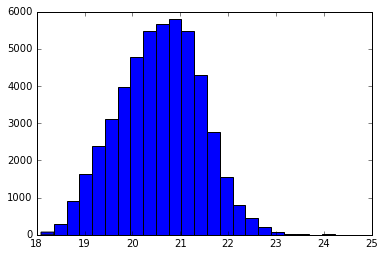

In [24]:
#plt.hist(-1*catalog, bins = 30)
plt.hist(-1*mags, bins = 30);
plt.xlim([18,25]);

In [25]:
#downsample here
hist, bin_edges = np.histogram(-1*mags, bins = 30)
max_mag= bin_edges[np.argmax(hist)+1]
downsample_idxs = set()
makeshift_hist = []
length = len(hist)

#Index of the bin we want to match to. 
match_idx = -16
low, high = bin_edges[match_idx:match_idx+2]

in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]

ratio = float(len(in_bin_idxs))/hist[match_idx] #the ratio by which to downsample to. 

#This will print the relative sizes of the bin selected, and its edges. 
print len(in_bin_idxs), hist[match_idx]
print low, high
print ratio
#work backwords in bins, from brightest to dimmest and randomly downsample. 
for real_idx, count in enumerate(reversed(hist)):
    idx = length-real_idx-1
    low, high = bin_edges[idx:idx+2]
    
    in_bin_idxs = np.where(np.logical_and(low <= -1*catalog, -1*catalog <= high))[0]

    # if our SHAM has more galaxies then we wanted to downsample to, just leave them all in. 
    # This should only happen in really bright bins
    if in_bin_idxs.shape[0] <= np.ceil(ratio*count):
        sampled_idxs = in_bin_idxs
    else:
        # else, downsample to the correct ratio
        sampled_idxs = np.random.choice(in_bin_idxs, size = int(np.ceil(ratio*count)), replace = False)

    downsample_idxs = downsample_idxs | set(sampled_idxs) #add the downsample idxs to our list
    
downsampled_catalog = catalog[np.array(list(downsample_idxs), dtype=int)]

2834 1559
22.0945201989 22.3614357109
1.81783194355


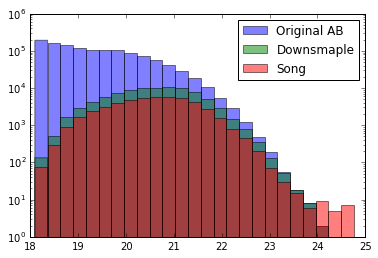

In [26]:
plt.hist(-1*catalog, bins = bin_edges, label = 'Original AB', alpha = 0.5)
plt.hist(-1*downsampled_catalog, bins = bin_edges, alpha = 0.5, label = "Downsmaple")
plt.hist(-1*mags, bins = bin_edges, alpha = 0.5, label = 'Song');
plt.xlim([18,25]);
plt.legend(loc='best')
plt.yscale('log')

Yay! It worked. 

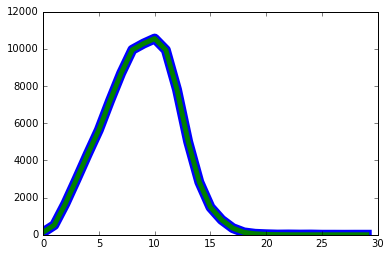

In [27]:
plt.plot(hist*ratio, lw = 10)
plt.plot(np.histogram(-1*downsampled_catalog, bins = bin_edges)[0], lw = 5)

Yeah! let's save the indexs. 

In [28]:
#put the indicies into an array the size of our original catalog
downsampled_idxs_array = np.zeros_like(valid_idxs, dtype=bool)
counter = 0
for idx, val in enumerate(valid_idxs):
    if val:
        if counter in downsample_idxs:
            downsampled_idxs_array[idx] = True
        counter+=1


downsampled_idxs_array= np.where(valid_idxs)[0][np.array(list(downsample_idxs))]

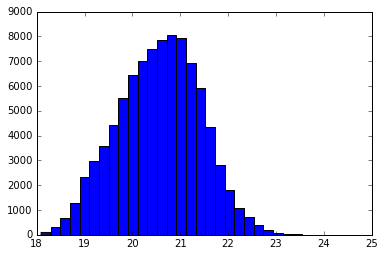

In [30]:
plt.hist(-1*full_catalog[downsampled_idxs_array], bins = 30);

In [ ]:
# save them! 
np.savetxt('gama_matched_catalog.npy', full_catalog)
np.savetxt('gama_matched_catalog_idxs.npy', downsampled_idxs_array)

In [ ]:
# alternatively, you could just add it as a column to the halo table we have

halocat.halo_table['gal_mag'] = np.ones_like(halocat.halo_table['gal_mag'])*60 #pu t60 in the ones that are empty
halocat.halo_table['gal_mag'][downsampled_idxs_array] = full_catalog

# can also slice down our full catalog now

galaxy_catalog = halocat.halo_table[downsampled_idxs_array]

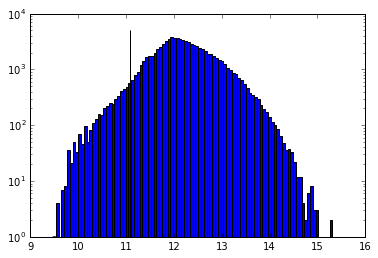

In [33]:
plt.hist(np.log10(halocat.halo_table[downsampled_idxs_array]['halo_mvir']), bins = 100);
plt.vlines(np.log10(200*halocat.particle_mass), 0, 5e3)
plt.yscale('log')

In [47]:
print '%e'%halocat.particle_mass

5.914214e+08
